## 3.1 Course Review EDA  

This notebook demonstrate the Exploratory Data Analysis (EDA) on the course review textual data.
  
*Credit to Jonathan Oheix:* some of the codes in this notebook is modified based on an article written by Jonathan Oheix about using NPL and Topic Modeling for analyzing hotel reviews.  
https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e

### Import basic libraries

In [1]:
# the basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import preprocessing and modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.options.display.max_colwidth = 350

---
### This notebook analyzed the reviews from:  
***Course Name: Review from 'Machine Learning by Stanford University, Andrew Ng' on Coursera***  

### Data Import and assign bad/non-bad reviews (bad review = 1)

In [2]:
# the data is scraped from Coursera.org using the codes from notebook 01.1
path = '../data/reviews_machine_learning.csv'
reviews = pd.read_csv(path)

In [3]:
# quick pre-processing, dropping columns and remove rows with null values
reviews.drop(columns=['Unnamed: 0'], inplace=True)
reviews.dropna(inplace=True)

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12888 entries, 0 to 12887
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          12888 non-null  object
 1   date_of_review  12888 non-null  object
 2   rating          12888 non-null  int64 
 3   course_href     12888 non-null  object
dtypes: int64(1), object(3)
memory usage: 503.4+ KB


In [5]:
# get the distribution of review ratings
reviews['rating'].value_counts()

5    9944
4    2540
3     249
1      88
2      67
Name: rating, dtype: int64

In [6]:
reviews['rating'].value_counts(normalize=True)

5    0.771570
4    0.197083
3    0.019320
1    0.006828
2    0.005199
Name: rating, dtype: float64

In [7]:
# create review label: 1 - 3: bad reviews, 4/5: good reviews
reviews['review_is_bad'] = reviews['rating'].map(lambda x: 1 if x < 4 else 0)

In [43]:
reviews['review_is_bad'].value_counts(normalize=True)

0    0.968653
1    0.031347
Name: review_is_bad, dtype: float64

In [8]:
reviews.head(1)

,review,date_of_review,rating,course_href,review_is_bad
0,"This is an extremely basic course. Machine learning is built on mathematics, yet this course treats mathematics as a mysterious monster to be avoided at all costs, which unfortunately left this student feeling frustrated and patronized. So much time is wasted in the videos with arduous explanations of trivialities, and so little taken up with t...","Mar 18, 2017",1,/learn/machine-learning,1


### Data Pre-processing 
#### `tokenize`, `stopwords`, `lemmatize`, `pos_tag`

In [9]:
# import 
import string
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [10]:
# define a function to associate the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    stop.append('course') # add stopword to the lit
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [12]:
# clean text data
reviews["review_clean"] = reviews["review"].apply(lambda x: clean_text(x))

In [13]:
# add number of characters column
reviews["nb_chars"] = reviews["review"].apply(lambda x: len(x))

# add number of words column
reviews["nb_words"] = reviews["review"].apply(lambda x: len(x.split(" ")))

In [14]:
reviews.head(1)

,review,date_of_review,rating,course_href,review_is_bad,review_clean,nb_chars,nb_words
0,"This is an extremely basic course. Machine learning is built on mathematics, yet this course treats mathematics as a mysterious monster to be avoided at all costs, which unfortunately left this student feeling frustrated and patronized. So much time is wasted in the videos with arduous explanations of trivialities, and so little taken up with t...","Mar 18, 2017",1,/learn/machine-learning,1,extremely basic machine learn build mathematics yet treat mathematics mysterious monster avoid cost unfortunately leave student feeling frustrate patronized much time waste videos arduous explanation triviality little take impart meaningful knowledge end abandon video altogether quizes basic largely base recall rather application knowledge prog...,997,152


### The most frequent words

In [15]:
from nltk import FreqDist

In [16]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top most frequent words
    d = words_df.nlargest(columns="count", n = terms)
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count', xlabel='Words')
    plt.xticks(rotation = 30)
    plt.show()

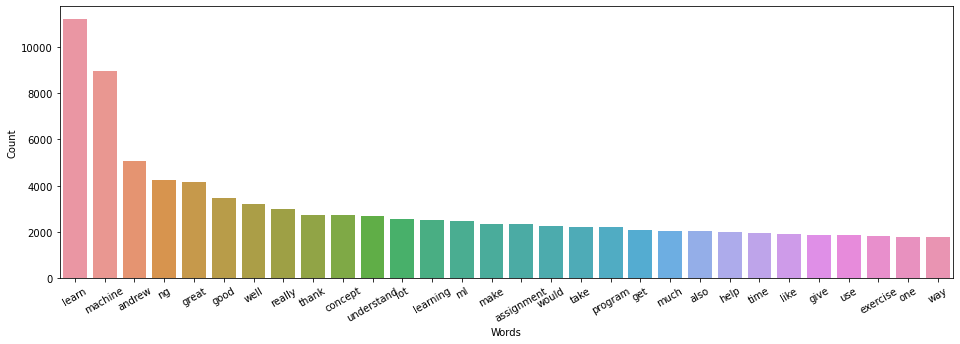

In [17]:
freq_words(reviews['review_clean'])

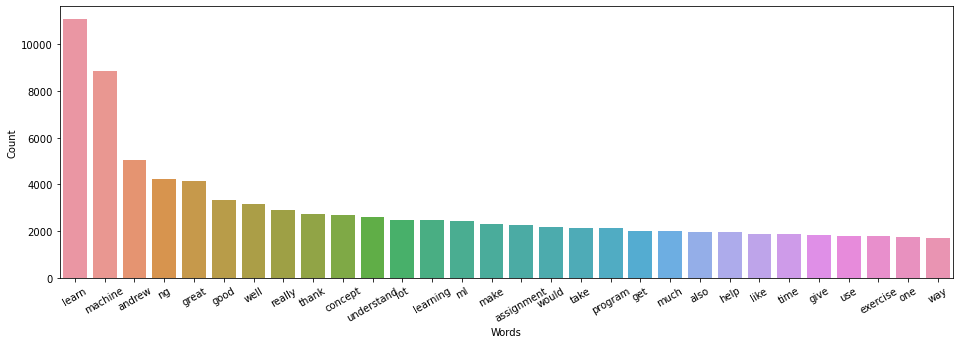

In [18]:
freq_words(reviews[reviews['review_is_bad']==0]['review_clean'])

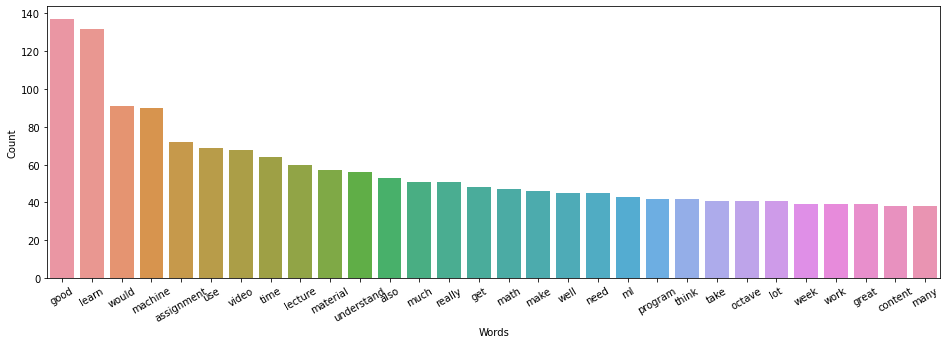

In [19]:
freq_words(reviews[reviews['review_is_bad']==1]['review_clean'])

### Sentiment Analysis

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [21]:
# add sentiment anaylsis columns
sid = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["review"].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

#### `doc2vec`  
documentation: https://radimrehurek.com/gensim/models/doc2vec.html

In [22]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [23]:
# create doc2vec vector columns
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec = reviews["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec.columns = ["doc2vec_vector_" + str(x) for x in doc2vec.columns]
reviews = pd.concat([reviews, doc2vec], axis=1)

#### `TF-IDF`

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
# add tf-idfs columns

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews.index
reviews = pd.concat([reviews, tfidf_df], axis=1)

### EDA

In [26]:
reviews.head(1)

,review,date_of_review,rating,course_href,review_is_bad,review_clean,nb_chars,nb_words,neg,neu,...,word_wu,word_ya,word_year,word_yes,word_yet,word_you,word_young,word_youtube,word_zero,word_área
0,"This is an extremely basic course. Machine learning is built on mathematics, yet this course treats mathematics as a mysterious monster to be avoided at all costs, which unfortunately left this student feeling frustrated and patronized. So much time is wasted in the videos with arduous explanations of trivialities, and so little taken up with t...","Mar 18, 2017",1,/learn/machine-learning,1,extremely basic machine learn build mathematics yet treat mathematics mysterious monster avoid cost unfortunately leave student feeling frustrate patronized much time waste videos arduous explanation triviality little take impart meaningful knowledge end abandon video altogether quizes basic largely base recall rather application knowledge prog...,997,152,0.113,0.8,...,0.0,0.0,0.0,0.0,0.113059,0.0,0.0,0.0,0.0,0.0


In [27]:
# show is_bad_review distribution
reviews['review_is_bad'].value_counts()

0    12484
1      404
Name: review_is_bad, dtype: int64

In [28]:
# show is_bad_review distribution
reviews['review_is_bad'].value_counts(normalize = True)

0    0.968653
1    0.031347
Name: review_is_bad, dtype: float64

#### WordCloud

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [30]:
# wordcloud function


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 45, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

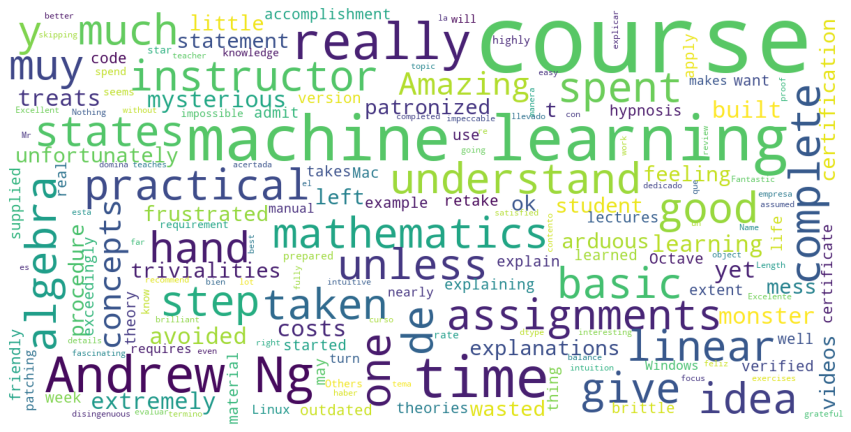

In [31]:
# print wordcloud of all reviews
show_wordcloud(reviews["review"])

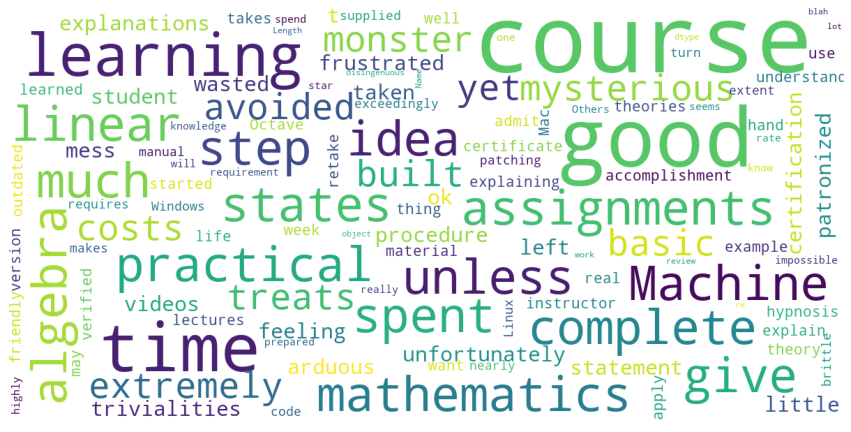

In [32]:
# print wordcloud of bad reviews
show_wordcloud(reviews[reviews['review_is_bad']==1]['review'])

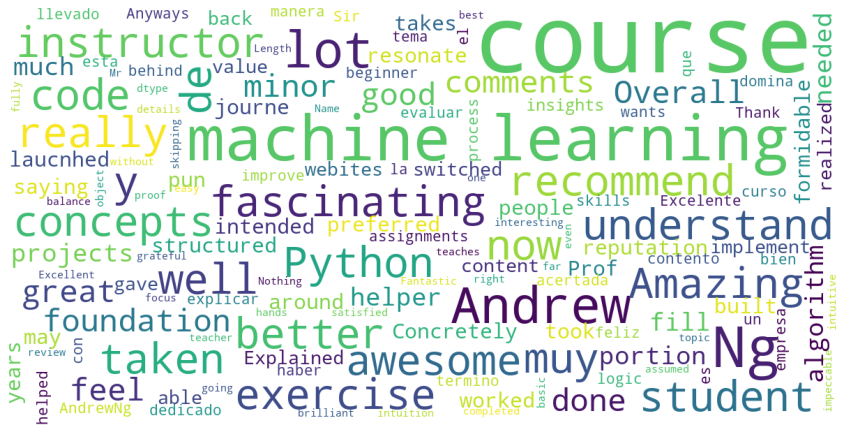

In [33]:
# print wordcloud of good reviews
show_wordcloud(reviews[reviews['review_is_bad']==0]['review'])

#### Sentiment: reviews with highest compound scores

In [34]:
# highest positive sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("compound", ascending = False)[["review", "compound"]].head(10)

,review,compound
3008,"Before starting this course, I had no previous knowledge of machine learning and I had never programmed in Octave and I have little/no programming skills. This is a 11-week course and so I was not sure if I would make it to the end (or even get through the first week) but I was keen to learn something new. Positive Aspects: The course is extrem...",0.9984
415,"I'm not crazy about online learning. There are certain aspects of classroom learning that online learning can't give. But as far as online learning goes, this course is probably about as good as it ever gets.Prof. Ng gives very clear expositions of the fundamentals of machine learning. Anyone taking this class and completing the assignments ...",0.9979
4075,"I am in the middle of the course, but I have already made my opinion. I think it is really great course. I have never felt so good feeling from studying. I'm so thankful for Andrew NG's work and he is master of his craft. Very nice and pleasant teacher. I wish I have such teachers at school and university.\nI highly recommend pass this course f...",0.9973
3176,"My review concerns partially the course and partially the Coursera concept as this was my first on-line course and I cannot distinguish between those two.My experience was simply great, I felt that it was time well spend, for example compares to my company provided trainings and I'm hoping to return to another course.I have quite strong backgro...",0.9968
3301,"Andrew Ng is such a great person and teacher! This course is just pure gold and this is my first MOOC.Andrew smoothly guides you through the most important concepts of machine learning, doing so, that you really understand things very well. He eaxplains pretty difficult things in easy way, generalize ideas very well, so, that you don't need to ...",0.9963
3428,"This course has to be one of the most magnificent course that I have ever taken. I spent sometime on other online courses on machine learning but did not complete them because the tutors didn't connect with me, the way Andrew did and that has been one of the primary reasons why I love this course and as a result of which the subject Machine Lea...",0.9963
3200,"What a great course! I really loved the pedagogical arrangement of this course. Skipping optional but complicated proofs was a smart move for some maybe not so for a select few topics but I realize that they were necessary to make this class as interesting as possible, and interesting it really is, without a doubt.One little complaint I have is...",0.9963
3187,"Really an amazing and wonderful course for anyone who would like to dive into the depths of machine learning. I am a student who is completely from a very very different background. To be frank i didn't even expect that I could complete/understand anything about machine learning. But Dr. Andrews,.... sir hats off to you. You are the real hero. ...",0.9962
3005,"Before I go into why I liked this course so much, let me give a little context on my motivation to taking it. My background is a Bachelors in Math, and 9 years working in finance in a role involving very little computer science or statistics. I wanted a change of industries into the world of Data, for which a significant amount of learning and ...",0.9962
3196,"I highly recommend all of those who have data-related background, are extremely interested and fascinated about the topics of machine learning, and would like to start building their career in this field to attend this course as their first step. Professor Ng is indeed very knowledgeable and is also a great lecturer. Throughout this course he n...",0.9958


#### Sentiment: reviews with highest positive scores

In [35]:
# highest positive sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
2822,very fine :),0.843
2630,great course.very useful and fun.,0.837
3154,Loved it. Easy and Excellent Course,0.778
2436,Excellent course and excellent supporting mateiral,0.774
2444,"Good class, with useful, interesting assignments!",0.746
2542,simply amazing! good for solid foundation,0.741
2629,Very ambitious and amazing course,0.713
2628,Great course. Easy to understand.,0.700
2648,Great course - thanks very much,0.700
2688,"It is great, I recommend it.",0.688


#### Sentiment: reviews with highest negative scores

In [36]:
# highest negative sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
73,WORST tutorial ever done...very bad experience,0.676
2579,One problem: the sound quality is bad!,0.565
75,not interested ...tutor accent not good,0.538
375,Audio quality is very bad.,0.487
367,The scripting was inadequate.,0.474
145,"Weak math basis, tasks are not too interesting",0.462
69,Problems sets increasingly do not follow the lectures. Too bad.,0.437
2656,I loved the course... I hated R,0.416
1974,"I'll only mentions things I didn't like: sound/video quality is poor, lack of lecture notes.",0.406
374,"quite boring, need s.t new",0.393


#### Sentiment: Good reviews vs. bad reviews

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


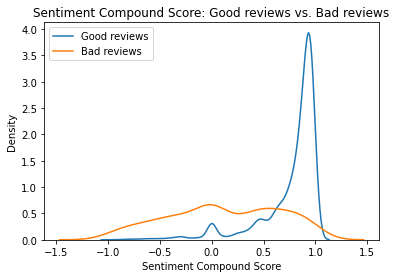

In [37]:
for x in [0, 1]:
    subset = reviews[reviews['review_is_bad'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)
    plt.title('Sentiment Compound Score: Good reviews vs. Bad reviews')
    plt.xlabel('Sentiment Compound Score')
    plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


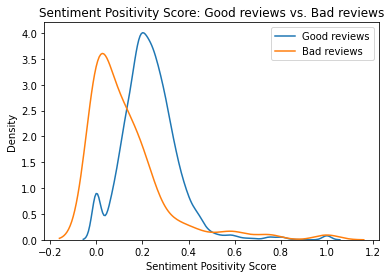

In [38]:
for x in [0, 1]:
    subset = reviews[reviews['review_is_bad'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['pos'], hist = False, label = label)
    plt.title('Sentiment Positivity Score: Good reviews vs. Bad reviews')
    plt.xlabel('Sentiment Positivity Score')
    plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


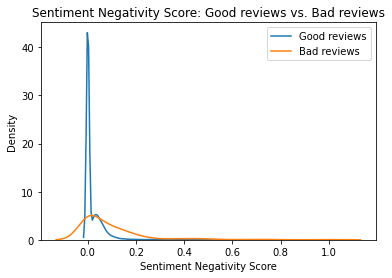

In [39]:
for x in [0, 1]:
    subset = reviews[reviews['review_is_bad'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['neg'], hist = False, label = label)
    plt.title('Sentiment Negativity Score: Good reviews vs. Bad reviews')
    plt.xlabel('Sentiment Negativity Score')
    plt.legend()

In [40]:
# uncomment to run 
# reviews.to_csv('../data/reviews_ml_modeling.csv')

In [41]:
# end of notebook